In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
%matplotlib inline

In [3]:
data = pd.read_csv("employee_sat.csv")

missing_values = data.isnull().sum()
missing_values

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64

In [4]:
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


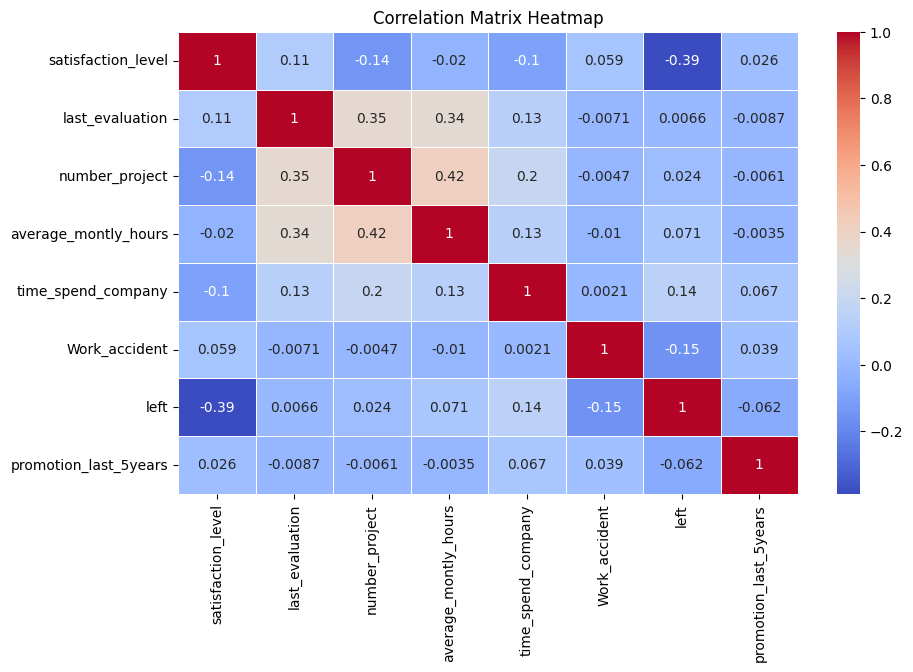

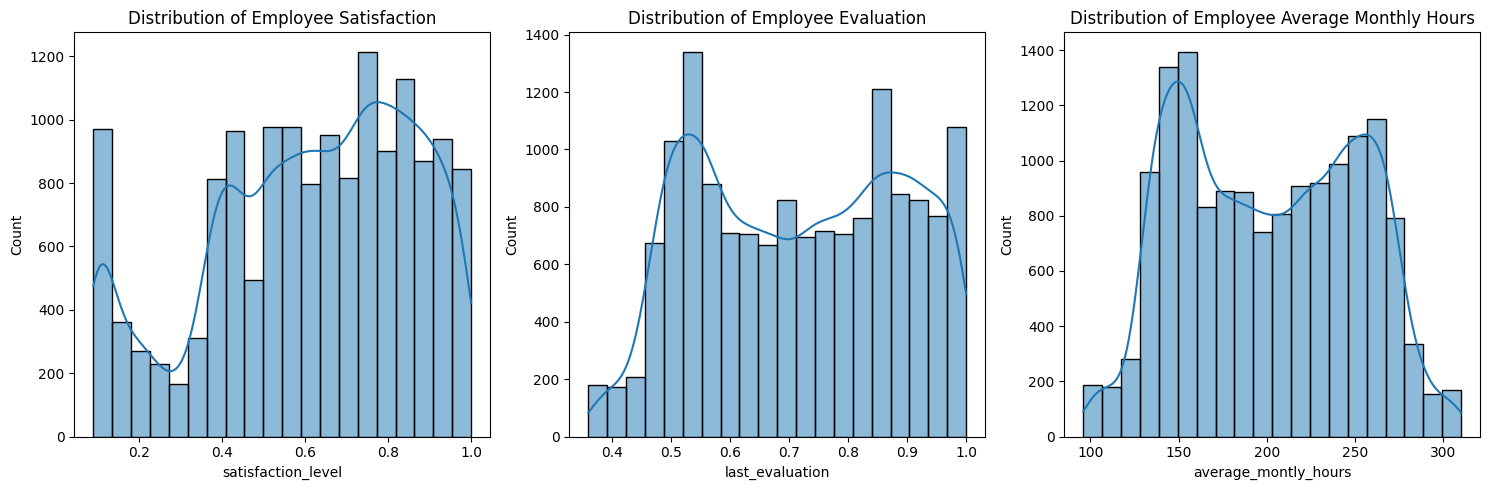

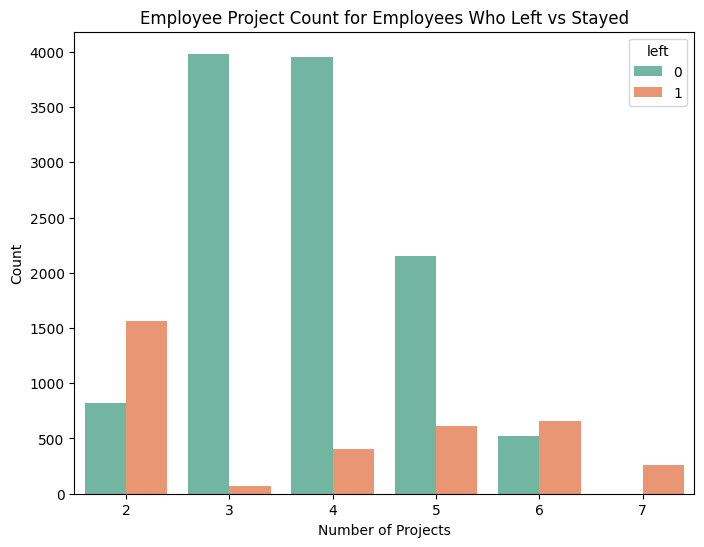

In [5]:
# Heatmap of the corr matrix

plt.figure(figsize=[10,6])
correlation_matrix = data.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

# 2.2 Distribution plots for satisfaction_level, last_evaluation, and average_montly_hours
plt.figure(figsize=(15, 5))

# Employee Satisfaction
plt.subplot(1, 3, 1)
sns.histplot(data['satisfaction_level'], kde=True, bins=20)
plt.title('Distribution of Employee Satisfaction')

# Employee Evaluation
plt.subplot(1, 3, 2)
sns.histplot(data['last_evaluation'], kde=True, bins=20)
plt.title('Distribution of Employee Evaluation')

# Employee Average Monthly Hours
plt.subplot(1, 3, 3)
sns.histplot(data['average_montly_hours'], kde=True, bins=20)
plt.title('Distribution of Employee Average Monthly Hours')

plt.tight_layout()
plt.show()

# 2.3 Bar plot of employee project count for employees who left and stayed
plt.figure(figsize=(8, 6))
sns.countplot(x='number_project', hue='left', data=data, palette='Set2')
plt.title('Employee Project Count for Employees Who Left vs Stayed')
plt.xlabel('Number of Projects')
plt.ylabel('Count')
plt.show()

2.1 Correlation Matrix Heatmap:
The heatmap shows the correlations between numerical features. Some key observations:

Satisfaction Level is negatively correlated with whether an employee left the company, meaning lower satisfaction is associated with higher turnover.
Average Monthly Hours has a weak positive correlation with turnover, implying that higher monthly hours could slightly increase turnover.
Last Evaluation shows a slight positive correlation with turnover, suggesting that employees with higher evaluations might also be more likely to leave in some cases.

2.2 Distribution Plots:
Employee Satisfaction: The distribution is right-skewed, indicating that most employees have relatively high satisfaction, but there are notable lower satisfaction levels too.
Employee Evaluation: This shows a bimodal distribution, indicating two peaks in employee evaluations, with some employees being rated very highly and some rated moderately.
Average Monthly Hours: The distribution suggests most employees work between 150 and 250 hours monthly, with some working much more or less.

2.3 Bar Plot of Employee Project Count (Left vs Stayed):
The bar plot shows the distribution of project counts for employees who stayed versus those who left:

Employees who worked on 3, 4, or 5 projects tend to stay more, while those working on 2 or 6-7 projects tend to leave more frequently.
This suggests that employees with too few or too many projects are more likely to leave, which could indicate under or overwork as a contributing factor to turnover.

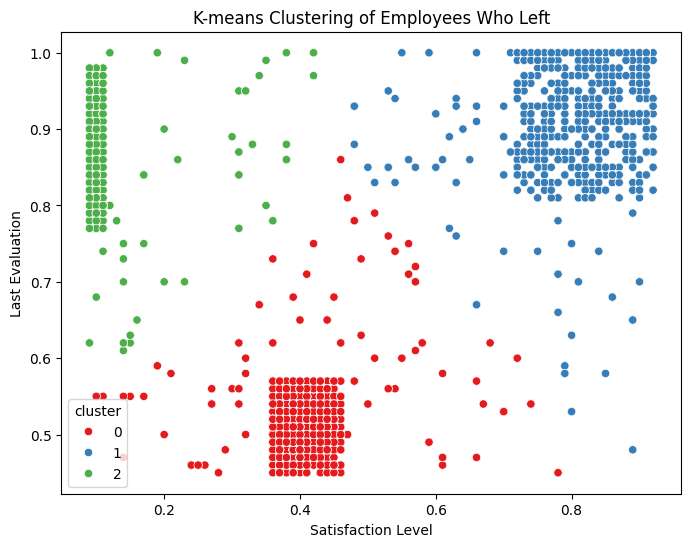

array([[0.41014545, 0.51698182],
       [0.80851586, 0.91170931],
       [0.11115466, 0.86930085]])

In [6]:
from sklearn.cluster import KMeans

# 3.1 Filter data for employees who left and select necessary columns
left_employees = data[data['left'] == 1][['satisfaction_level', 'last_evaluation']]

# 3.2 Perform K-means clustering into 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
left_employees['cluster'] = kmeans.fit_predict(left_employees)

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='satisfaction_level', y='last_evaluation', hue='cluster', data=left_employees, palette='Set1')
plt.title('K-means Clustering of Employees Who Left')
plt.xlabel('Satisfaction Level')
plt.ylabel('Last Evaluation')
plt.show()

# Cluster centers
cluster_centers = kmeans.cluster_centers_

cluster_centers

The scatter plot shows the K-means clustering of employees who left, based on their satisfaction levels and last evaluation scores. The three clusters represent different groupings of employees who left.

Cluster Centers (Satisfaction and Evaluation):

Cluster 1: Low satisfaction and moderate evaluation.

Cluster 2: Moderate satisfaction and high evaluation.

Cluster 3: High satisfaction and lower evaluation.

Analysis:

Cluster 1: This group likely left due to dissatisfaction with their work, despite having moderate evaluations.

Cluster 2: This group has high evaluation scores but only moderate satisfaction, suggesting that high performance may not always correlate with job satisfaction.

Cluster 3: Employees in this group seem to have relatively high satisfaction but may have left due to lower evaluations, indicating a potential mismatch between their satisfaction and performance assessments.


In [7]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 4.1 Separate categorical and numerical variables
categorical_columns = ['Department', 'salary']
numerical_columns = ['satisfaction_level', 'last_evaluation', 'number_project', 
                     'average_montly_hours', 'time_spend_company', 'Work_accident', 
                     'promotion_last_5years']

# Convert categorical variables to numerical using get_dummies
categorical_data = pd.get_dummies(data[categorical_columns], drop_first=True)
numerical_data = data[numerical_columns]

# Combine numerical and categorical data
processed_data = pd.concat([numerical_data, categorical_data, data['left']], axis=1)

# 4.2 Stratified train-test split
X = processed_data.drop('left', axis=1)
y = processed_data['left']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# 4.3 Apply SMOTE to the training data
smote = SMOTE(random_state=123)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
y_train_smote.value_counts()

left
0    9142
1    9142
Name: count, dtype: int64

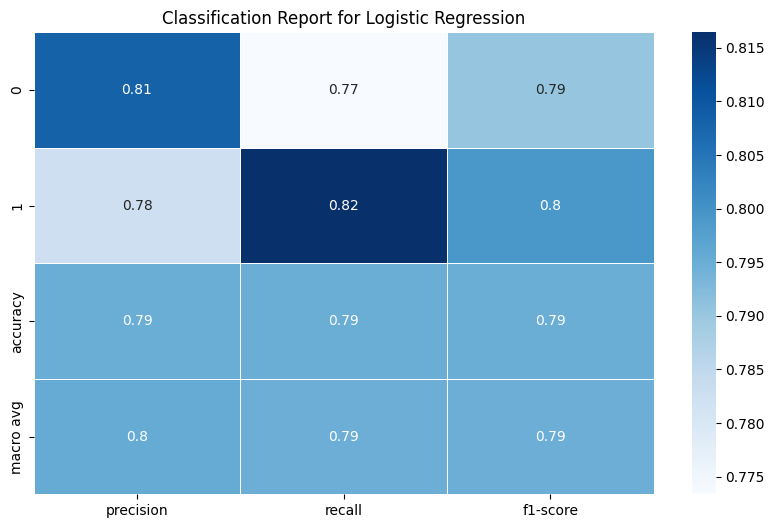

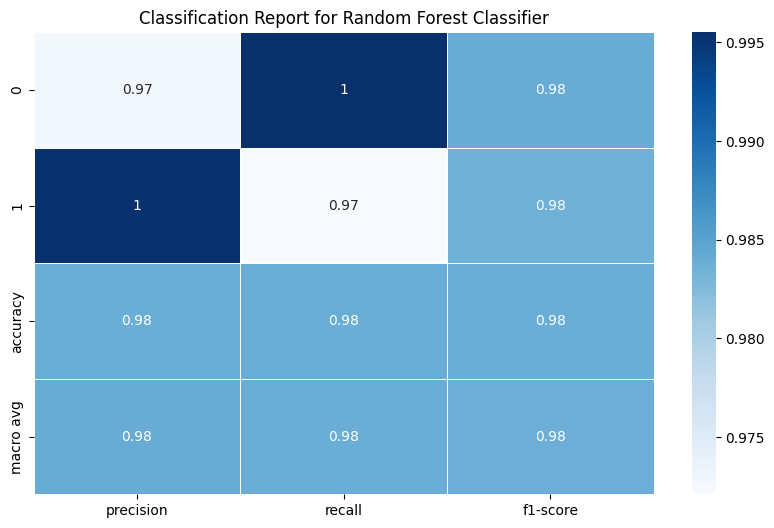

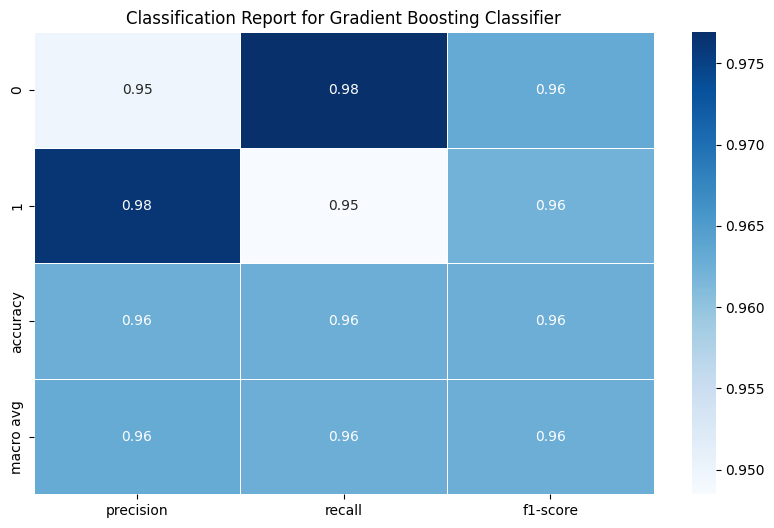

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict

# 5.1 Train Logistic Regression model with 5-fold cross-validation
log_reg = LogisticRegression(max_iter=1000, random_state=123)
log_reg_pred = cross_val_predict(log_reg, X_train_smote, y_train_smote, cv=5)

# 5.2 Train Random Forest Classifier with 5-fold cross-validation
rf_clf = RandomForestClassifier(random_state=123)
rf_pred = cross_val_predict(rf_clf, X_train_smote, y_train_smote, cv=5)

# 5.3 Train Gradient Boosting Classifier with 5-fold cross-validation
gb_clf = GradientBoostingClassifier(random_state=123)
gb_pred = cross_val_predict(gb_clf, X_train_smote, y_train_smote, cv=5)

# Plotting classification reports
log_report = classification_report(y_train_smote, log_reg_pred, output_dict=True)
rf_report = classification_report(y_train_smote, rf_pred, output_dict=True)
gb_report = classification_report(y_train_smote, gb_pred, output_dict=True)

# Function to plot classification report
def plot_classification_report(report, model_name):
    report_df = pd.DataFrame(report).transpose()
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues', linewidths=0.5)
    plt.title(f'Classification Report for {model_name}')
    plt.show()

# Plot the classification reports for each model
plot_classification_report(log_report, 'Logistic Regression')
plot_classification_report(rf_report, 'Random Forest Classifier')
plot_classification_report(gb_report, 'Gradient Boosting Classifier')

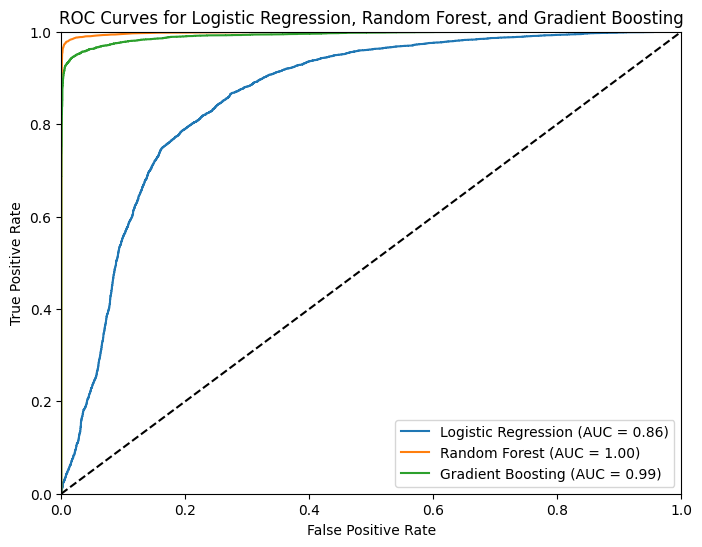

(array([[7070, 2072],
        [1678, 7464]], dtype=int64),
 array([[9101,   41],
        [ 255, 8887]], dtype=int64),
 array([[8931,  211],
        [ 471, 8671]], dtype=int64))

In [9]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

# 6.1 Calculate ROC AUC scores and plot ROC curves for each model

# Logistic Regression ROC
log_reg_prob = cross_val_predict(log_reg, X_train_smote, y_train_smote, cv=5, method="predict_proba")[:, 1]
log_fpr, log_tpr, _ = roc_curve(y_train_smote, log_reg_prob)
log_auc = roc_auc_score(y_train_smote, log_reg_prob)

# Random Forest ROC
rf_prob = cross_val_predict(rf_clf, X_train_smote, y_train_smote, cv=5, method="predict_proba")[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_train_smote, rf_prob)
rf_auc = roc_auc_score(y_train_smote, rf_prob)

# Gradient Boosting ROC
gb_prob = cross_val_predict(gb_clf, X_train_smote, y_train_smote, cv=5, method="predict_proba")[:, 1]
gb_fpr, gb_tpr, _ = roc_curve(y_train_smote, gb_prob)
gb_auc = roc_auc_score(y_train_smote, gb_prob)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(log_fpr, log_tpr, label=f'Logistic Regression (AUC = {log_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(gb_fpr, gb_tpr, label=f'Gradient Boosting (AUC = {gb_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curves for Logistic Regression, Random Forest, and Gradient Boosting')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# 6.2 Compute confusion matrices for each model
log_reg_pred_final = cross_val_predict(log_reg, X_train_smote, y_train_smote, cv=5)
rf_pred_final = cross_val_predict(rf_clf, X_train_smote, y_train_smote, cv=5)
gb_pred_final = cross_val_predict(gb_clf, X_train_smote, y_train_smote, cv=5)

# Confusion matrices
log_conf_matrix = confusion_matrix(y_train_smote, log_reg_pred_final)
rf_conf_matrix = confusion_matrix(y_train_smote, rf_pred_final)
gb_conf_matrix = confusion_matrix(y_train_smote, gb_pred_final)

log_conf_matrix, rf_conf_matrix, gb_conf_matrix

ROC/AUC: This will allow us to compare models based on their ability to distinguish between classes. Higher AUC means better performance.

Confusion Matrix: The confusion matrix will give insights into True Positives, False Positives, True Negatives, and False Negatives for each model.
Precision vs. Recall: Depending on the use case:

If minimizing false negatives is important (e.g., high cost of missing a positive case), prioritize recall.

If minimizing false positives is important (e.g., false alarms), prioritize precision.

In [10]:
# 7.1 Using the best model (Random Forest in this case) to predict on test data
rf_clf.fit(X_train_smote, y_train_smote)  # Train the Random Forest model on the entire train data
rf_prob_test = rf_clf.predict_proba(X_test)[:, 1]  # Get probability of employee leaving (class 1)

# 7.2 Categorize employees based on probability scores into zones
zones = pd.cut(rf_prob_test, bins=[0, 0.2, 0.6, 0.9, 1.0], 
               labels=['Safe Zone (Green)', 'Low-Risk Zone (Yellow)', 
                       'Medium-Risk Zone (Orange)', 'High-Risk Zone (Red)'])

# Create a DataFrame to show employee turnover probabilities and zone assignments
test_results = pd.DataFrame({'Probability of Turnover': rf_prob_test, 'Zone': zones})

# Display the results
test_results.head()

,Probability of Turnover,Zone
0,0.00,NaN
1,0.56,Low-Risk Zone (Yellow)
2,0.05,Safe Zone (Green)
3,0.01,Safe Zone (Green)
4,0.00,NaN


7.2 Retention Strategy Suggestions for Each Zone:

Safe Zone (Green) (Score < 20%):

Strategy: Employees in this zone show low likelihood of turnover. Regular check-ins, career development opportunities, and maintaining the current work environment would be sufficient.

Focus: Continued engagement, professional development, and periodic feedback.

Low-Risk Zone (Yellow) (20% < Score < 60%):

Strategy: Employees in this zone could be on the fence. Strategies should include personalized growth opportunities, targeted mentorship programs, or leadership opportunities to further increase engagement.

Focus: Proactive retention measures like better work-life balance, small incentives, or recognizing their contributions could help.

Medium-Risk Zone (Orange) (60% < Score < 90%):

Strategy: These employees are at risk of leaving and may be dissatisfied with specific aspects of their role. A one-on-one discussion to identify and address any concerns is key. Salary reviews, new projects, or offering a role change can also be effective.

Focus: Immediate action to address dissatisfaction, like workload reduction, recognition, salary adjustments, or training.

High-Risk Zone (Red) (Score > 90%):

Strategy: These employees are highly likely to leave soon. Urgent intervention is required, such as offering retention bonuses, fast-tracking promotions, or providing opportunities that align with their long-term goals.

Focus: Urgent measures such as counteroffers, leadership development plans, or fast-tracking career advancement.

Conclusion:
This approach of categorizing employees into zones based on their probability of turnover allows you to implement targeted retention strategies, ensuring that resources are focused on high-risk employees while maintaining engagement across other zones.